<a href="https://colab.research.google.com/github/MerkulovDaniil/sber21_fmin/blob/sources/notebooks/6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preconditioned conjugate gradients

## Idea

In [3]:
#@title Imports
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as linalg

### Condition Number

We can define the condition number of a matrix as the ratio between the max eigenvalue and min eigenvalue of that matrix. Remember that the eigenvectors of a general `nxn` matrix point in `n` orthogonal directions and the eigenvalue corresponds to how much the vector is "stretched" in that direction. Therefore, the condition number represents how oblong the contour graph of the matrix is. 

![condition number math definition](https://wikimedia.org/api/rest_v1/media/math/render/svg/8cb09561518ede7417fff130591cf33278cdb7d7)

In [4]:
def condition(A):
  eigen_decomposition = np.linalg.eig(A)
  eigenvalues = eigen_decomposition[0]
  return abs(max(eigenvalues))/abs(min(eigenvalues))


The smallest the condition number can ever be is 1, when the max and min eigenvalues are the same. For example, in the case of the identity matrix. As the condition number of a matrix increases, it gets stretched along one eigenvector significantly more than another, creating this oblong shape in its isocontour graph.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: The following kwargs were not used by contour: 'linewidth'
  app.launch_new_instance()


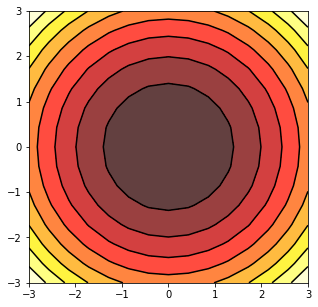

In [5]:
#@title Isocontour Graph with respect to Condition Number { run: "auto" }
condition_number =  1 #@param {type:"slider", min:1, max:10, step:1}
resolution = 15

def f(x, y):
  xbar = np.concatenate([x.reshape([resolution ** 2, 1]), y.reshape([resolution ** 2, 1])], 1)
  A = np.matrix([[1, 0], [0, 1/condition_number]])
  return np.diag(0.5 * xbar * A * xbar.T).reshape([resolution, resolution])

xs = np.linspace(-3, 3, resolution)
ys = np.linspace(-3, 3, resolution)
X, Y = np.meshgrid(xs, ys)

plt.figure(figsize=(5,5))
plt.contourf(X, Y, f(X, Y), 8, alpha=.75, cmap=plt.cm.hot)
C = plt.contour(X, Y, f(X,Y), 8, colors='black', linewidth=.5)


### How does Condition Number relate to Gradient Descent?

In general, minimizing along the gradient (i.e. solving for `x` such that `Ax=b`) is not very efficient when the condition number of `A` is large, because the gradient is very weak along the eigenvector with the smallest eigenvalue. Instead of converging quickly to the minimum value, conjugate gradient descent keeps bouncing back and forth between the orthogonal directions and converges very slowly.

We can see this in action with the example below. With the same starting point and number of steps, gradient descent is able to get much closer to the true optimum for the function where A has a low condition number.

In [6]:
def conjugate_gradient_descent(x_start, steps=3):
  x = x_start
  points = x_start.T
  for i in range(steps):
    d = -A * x
    alpha = float(d.T * d / (d.T * (A * d)))
    x = x + alpha * d
    points = np.concatenate([points, x.T], 0)
  return points

A = 
 [[1.  0.2]
 [0.4 0.1]]
Condition Number of A:  58.48290098502027 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: The following kwargs were not used by contour: 'linewidth'


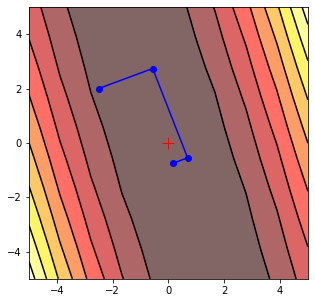

In [7]:
#@title Conjugate Gradient Descent with High Condition Number

A = np.matrix([[1, 0.2], [0.4, 0.1]])
x0 = np.matrix([[-2.5],[2.0]])

print("A = \n", A)
print("Condition Number of A: ", condition(A), "\n")

result = conjugate_gradient_descent(x0)

def f(x, y):
  xbar = np.concatenate([x.reshape([resolution ** 2, 1]), y.reshape([resolution ** 2, 1])], 1)
  return np.diag(0.5 * xbar * A * xbar.T).reshape([resolution, resolution])

resolution = 10
xs = np.linspace(-5, 5, resolution)
ys = np.linspace(-5, 5, resolution)
X, Y = np.meshgrid(xs, ys)

plt.figure(figsize=(5,5))
plt.contourf(X, Y, f(X, Y), 8, alpha=.6, cmap=plt.cm.hot)
C = plt.contour(X, Y, f(X,Y), 8, colors='black', linewidth=.5)
plt.plot(result[:,0], result[:,1], '-bo')
plt.plot(0,0, 'r+', markersize=12)

A = 
 [[1.  0.2]
 [0.4 0.5]]
Condition Number of A:  3.026756149155491 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: The following kwargs were not used by contour: 'linewidth'


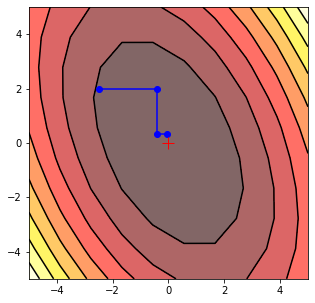

In [8]:
#@title Conjugate Gradient Descent with Low Condition Number

A = np.matrix([[1, 0.2], [0.4, 0.5]])
x0 = np.matrix([[-2.5],[2.0]])

print("A = \n", A)
print("Condition Number of A: ", condition(A), "\n")

result = conjugate_gradient_descent(x0)

def f(x, y):
  xbar = np.concatenate([x.reshape([resolution ** 2, 1]), y.reshape([resolution ** 2, 1])], 1)
  return np.diag(0.5 * xbar * A * xbar.T).reshape([resolution, resolution])

resolution = 10
xs = np.linspace(-5, 5, resolution)
ys = np.linspace(-5, 5, resolution)
X, Y = np.meshgrid(xs, ys)

plt.figure(figsize=(5,5))
plt.contourf(X, Y, f(X, Y), 8, alpha=.6, cmap=plt.cm.hot)
C = plt.contour(X, Y, f(X,Y), 8, colors='black', linewidth=.5)
plt.plot(result[:,0], result[:,1], '-bo')
plt.plot(0,0, 'r+', markersize=12)

### Preconditioners for Gradient Descent

Preconditioning is the idea of transforming the solution space to make it easier to solve (in our case we want to make it easier to apply gradient descent). In our example, we want to take `Ax=b` where the matrix `A` has a high condition number and transform it by multiplying a matrix `M` to solve `(MA)x=Mb` such that the matrix `MA` has a low condition number or in other words when it is approximately the identity matrix. We can do this by defining the matrix `M` to be approximately be the inverse of `A`.

In [9]:
def preconditioned_conjugate_gradient_descent(x_start, Minv, steps=3):
  x = x_start
  points = x_start.T
  r = -A * x
  norm_r = np.linalg.norm(r)
  z = Minv * r
  p = z
  for i in range(steps):
    delta = r.T * z
    alpha = float(delta / (p.T * (A * p)))
    x = x + alpha * p
    points = np.concatenate([points, x.T], 0)
    r = r - (alpha * A * p)
    if np.linalg.norm(r) > norm_r:
      return points
    norm_r = np.linalg.norm(r)
    z = Minv * r
    beta = float(r.T * z / (delta))
    p = z + beta * p
  return points

#### Generating the Preconditioner

There are many ways to generate `M` that you can choose between depending on the properties of `A`. But we will only discuss Incomplete LU factorization.


#### A brief reminder of LU factorization

If `A` can be writtena s the product of a lower triangular matrix `L` and an upper triangular matrix `U`, then we can use this to more easily solve for `x`.

`PA = LU`

`Ax = b` -> `L(Ux) = Pb` 

Solve `Ly = Pb` then solve `Ux = y`.

Because L and U are triangular matrices, the new equations can be solved using forward and backward substitution. We only need to compute the LU decomposition once in order to repeatedly solve the equation for different values of `b`. So in practice, even though we are doing a decomposition and solving 2 linear equations, this approach is faster because the new equations are much easier to solve.

**The problem with LU Factorization**

Many times, even though the matrix `A` is sparse, its LU decomposition might result in non-sparse triangular matrices. This means that there are a lot more computations that are needed in order to solve the resulting equations. In this case, we can approximate the LU decomposition by setting all the values that are near 0 to 0, forcing sparcity in the decomposition. This results in the incomplete LU factorization.



#### Incomplete LU Factorization

Since `A` is approximately equal to `LU`, the inverse of `A` is approximately `U^-1L^-1`. We can then use `U^-1L^-1` as our preconditioner `M` to approximate the inverse of A.


In [13]:
def GetILUPreconditioner(A):
  P,L,U = linalg.lu(A)
#   L[L < 0.2] = 0
#   U[U < 0.2] = 0
  Minv = L*U
  return (P, Minv)


A = 
 [[1.  0.2]
 [0.4 0.1]]
Minv = 
 [[1. 0.]
 [0. 0.]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: The following kwargs were not used by contour: 'linewidth'


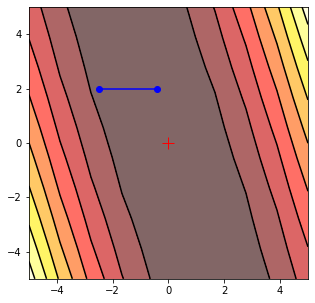

In [12]:
A = np.matrix([[1, 0.2], [0.4, 0.1]])
x0 = np.matrix([[-2.5],[2.0]])
P, Minv = GetILUPreconditioner(A)

print("A = \n", A)
print("Minv = \n", Minv)

result = preconditioned_conjugate_gradient_descent(x0, Minv, 5)

def f(x, y):
  xbar = np.concatenate([x.reshape([resolution ** 2, 1]), y.reshape([resolution ** 2, 1])], 1)
  return np.diag(0.5 * xbar * A * xbar.T).reshape([resolution, resolution])

resolution = 10
xs = np.linspace(-5, 5, resolution)
ys = np.linspace(-5, 5, resolution)
X, Y = np.meshgrid(xs, ys)

plt.figure(figsize=(5,5))
plt.contourf(X, Y, f(X, Y), 8, alpha=.6, cmap=plt.cm.hot)
C = plt.contour(X, Y, f(X,Y), 8, colors='black', linewidth=.5)
plt.plot(result[:,0], result[:,1], '-bo')
plt.plot(0,0, 'r+', markersize=12)

## Task

Consider boston house dataset and compare classical version of conjugate gradients `scipy.sparse.linalg.cg(A, b)` vs conjugate gradients with preconditioner `scipy.sparse.linalg.cg(A, b, M)` for the following preconditioners:

* Ideal preconditioner: $M = A^{-1}$
* Jacoby preconditioner: $M = \text{diag}(a_{ii}^{-1})$
* EXTRA: Incomplete LU factorization.

Plot the convergence on the one graph.

In [22]:
import scipy
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
boston = load_boston()
X = boston['data']
y = boston['target']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20,
                                                random_state=10101)
m = len(ytrain)

In [45]:
pars = []
funs = []

def callback_cg(xk):
    pars.append(xk)
    funs.append(1/m*np.linalg.norm(A @ xk - b))


A = Xtrain.T @ Xtrain
b = Xtrain.T @ ytrain
scipy.sparse.linalg.cg(A, b, callback=callback_cg)

(array([-1.07575932e-01,  6.13192823e-02, -3.04055900e-03,  5.13154927e-01,
         2.50646611e-01,  5.73224359e+00, -1.42453864e-02, -1.14510789e+00,
         1.89446485e-01, -1.23011836e-02, -3.21597748e-01,  1.60309057e-02,
        -4.13417402e-01]), 0)

In [ ]:
plt.ylabel('Residual norm')
plt.semilogy(funs, label = 'no-precond')
plt.xlabel('Iterations')
plt.legend()
plt.show()

In [42]:
def callback_cg(xk):
    pars.append(xk)
    funs.append(1/m*np.linalg.norm(A @ xk - b))

def best_M(A):
    ### Your code here
    return np.linalg.inv(A)

def Jacoby(A):
    ### Your code here
    return M

def incomplete_LU(A):
    P,L,U = linalg.lu(A)
    # L[L < 0.2] = 0
    # U[U < 0.2] = 0
    M = np.linalg.inv(U) @ np.linalg.inv(L)
    return M

(array([-0.10932847,  0.05536026,  0.00722342,  1.52949644, -1.93676841,
         5.90035616, -0.01418946, -1.07203528,  0.19333601, -0.01136086,
        -0.37425428,  0.01608414, -0.39090878]), 130)